In [2]:
import numpy as np 
from scipy import signal
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from IPython.display import Audio
import warnings
import librosa
warnings.filterwarnings('ignore')

<h1>Oscillators</h1><p>In a previous life, I spent a plethora of time thinking about layering detuned oscillators in the context of sound design and subtractive synthesis. Electronic musicians' trade often begins by throwing together a few waveforms and staring at the result through an oscilloscope. In no small part, this project is an extension of my love of electronic music and synthesizers but investigated through of machine learning.</p><h2>Goals</h2><p>This project aims to explore waveform generation in Python and investigate the plausibility of adapting known machine learning tools to tasks on short, basic waveforms.</p>
<h3>Waveforms</h3><p>The sampling rate, $\frac{1}{T}$ (in $Hz$ ($\frac{1}{s}$)) of a recording represents the number of amplitude measurements taken of a continuous time signal, $S(t)$ where $\{ t \in \mathbb{R} : t \ge 0 \}$, to turn it into a discrete time signal, $S(nT)$ where $\{ n \in \mathbb{Z} : n \ge 0 \}$.</p>

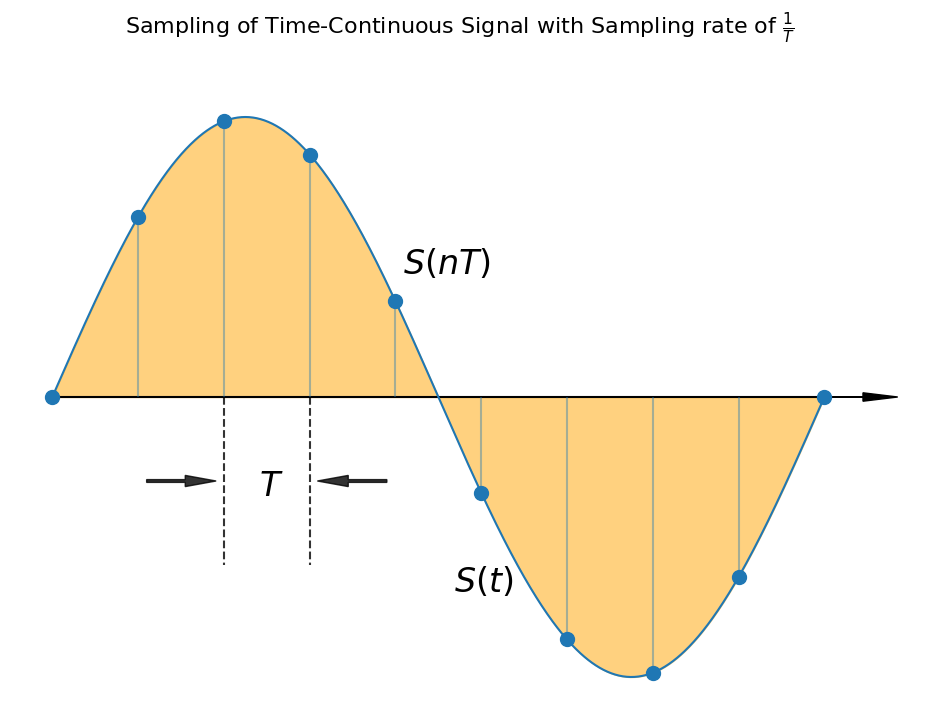

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))

# Define the sampling rate (in Hz) and duration (in seconds) of the waveform 
sampling_rate = 44100 
duration = 1 / 100
frequency = 440 

t = np.linspace(0, 1, 1000, endpoint=False) 
n = np.linspace(0, 1, 10)
#extending_arrow = np.linspace(1, 1.2, 1000 * (1.2 - 1), endpoint=False)
# Generate the waves
sin_env = np.sin(2 * np.pi * t) 
sin_samp = np.sin(2 * np.pi * n) 
x_axis = t * 0

#Plot x-axis
ax.plot(t, x_axis, color='black')
ax.arrow(1, 0, 0.05, 0, width=0, head_width=0.03, color='black')

# Plot the waveform 
ax.plot(t, sin_env, color='C0') 
#plot the sample points
ax.plot(n, sin_samp, 'bo', color='C0', markersize=10) 

#Fill the background
ax.fill_between(t, sin_env, x_axis, color='orange', alpha=0.5)

for i in range(n.shape[0]):
    ax.vlines(n[i], 0, sin_samp[i], alpha=0.4)

#Sampling graphics
arrow_alp = 0.8
arr_y_dev = -0.3
#left arrow
ax.arrow(n[2] - 0.1, arr_y_dev, 0.05, 0, width=0.01, head_width=0.04, head_length=.04, color='black', alpha=arrow_alp)
#right arrow
ax.arrow(n[3] + 0.1, arr_y_dev, -0.05, 0, width=0.01, head_width=0.04, head_length=.04, color='black', alpha=arrow_alp)
#left vline
ax.vlines(n[2], 0, -0.6, linestyle='--', color='black', alpha=arrow_alp)
#right vline
ax.vlines(n[3], 0, -0.6, linestyle='--', color='black', alpha=arrow_alp)
#text
ax.text((n[2] + n[3]) / 2 - 0.01, arr_y_dev - 0.05, r'$T$', fontsize=24)


ax.set_xlabel('') 
ax.set_ylabel('') 

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

for xlabel_i in ax.get_xticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
for xlabel_i in ax.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
for tick in ax.get_xticklines():
    tick.set_visible(False)
for tick in ax.get_yticklines():
    tick.set_visible(False)

ax.text(n[4] + 0.01, sin_samp[4] + 0.1, r'$S(nT)$', fontsize=24)
ax.text(n[5] - 0.035, sin_samp[5] - 0.35, r'$S(t)$', fontsize=24)

fig.suptitle(r'Sampling of Time-Continuous Signal with Sampling rate of $\frac{1}{T}$', fontsize=16)

plt.show() 

<p>In the above plot, notice that the time-continuous signal, $S(t)$, is measured every $T$ seconds (or $\frac{1}{T}$ times per second) which results in the time-discrete signal, $S(nT)$, with sampling rate $\frac{1}{T}$.</p><p>Each measurement of the time-continuous signal is called a <em>sample</em>. Confusingly, <em>sample</em> can also refer to short clips of audio: you've been warned. For a waveform (or... sample) with a sampling rate $\frac{1}{T}$ that is $t$ seconds long, there are $\frac{t}{T}$ samples in the clip.</p>

<h3>Sine Wave</h3><p>The most basic oscillator found in almost any field is the sine wave. Surely, no one would be caught calculating it's values by hand but it's simplicity in derivation, use, sight, and sound make it a must include whether it's being invoked in a Fourier expansion or as a bass thickener in a synth sound.</p>

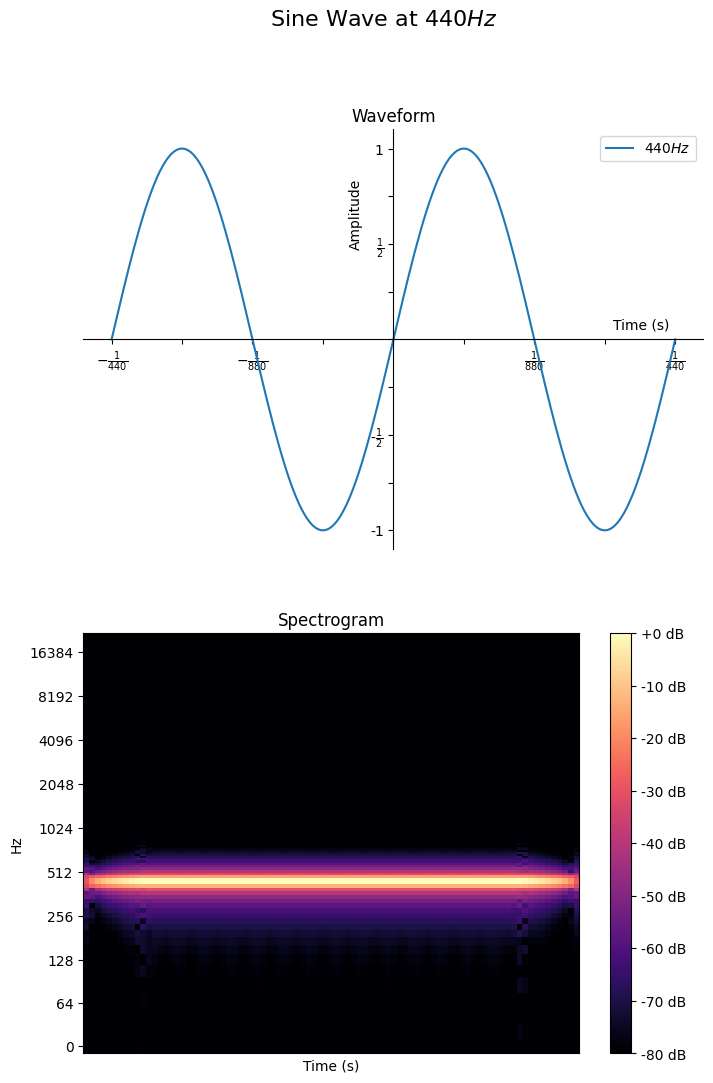

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

#NOTE: I am using two different time scales for the waveform
#and spectrograph outputs. I wanted to show both the shape of the wave 
#as well as the frequency distribution of the wave

#Generate the time-domain data
sampling_rate = 44100 
duration_time = 1 / 220
# Define the frequency (in Hz) of the sine wave 
frequency_time = 440
# Generate a time vector with evenly spaced samples 
t_time = np.linspace(0, duration_time, num=int(sampling_rate * duration_time))#, endpoint=False) 
# Generate the time-domain data
waveform_time = np.sin(2 * np.pi * frequency_time * t_time) 

# Plot the waveform 
ax1.plot(t_time, waveform_time) 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Amplitude') 

#Format top axis
ax1.title.set_text('Waveform')

ax1.spines['left'].set_position(('data', 1 / 440))
ax1.spines['bottom'].set_position(('data', 0))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.xaxis.set_label_coords(0.9,0.55)
ax1.set_xticks([x / 1760 for x in range(9)], labels=[r'$-\frac{1}{440}$', '', r'$-\frac{1}{880}$', '', '', '', r'$\frac{1}{880}$', '', r'$\frac{1}{440}$'])

ax1.set_yticklabels(['', '-1', '', r'-$\frac{1}{2}$', '','', '', r'$\frac{1}{2}$', '', '1', ''])
ax1.yaxis.set_label_coords(0.45,0.8)

frequency_handle = Line2D([0], [0], label='$440 Hz$', color=ax1.get_lines()[0].get_color())
ax1.legend(handles=[frequency_handle])


#Generate the frequency-domain data
#Notice that the duration of the two graphs are different!!
duration_freq = 1
frequency_freq = 440
t_freq = np.linspace(0, duration_freq, num=int(sampling_rate * duration_freq))#, endpoint=False) 

#Because of the hilarious behaviour of discontinuities, I'm smoothing the
#beginnings and endings of the clip to avoid artifacts in the 
#spectrograms
ramp_len = 5000
amp_smooth = np.ones(t_freq.shape[0])
amp_smooth[:ramp_len] = (1 / ramp_len) * np.arange(ramp_len) 
amp_smooth[t_freq.shape[0]: t_freq.shape[0] - ramp_len - 1: -1] = (1 / ramp_len) * np.arange(ramp_len) 

waveform_freq = np.sin(2 * np.pi * frequency_time * t_freq) 
waveform_freq_sin = waveform_freq * amp_smooth

#Short-Time Fourier transform to get a list of lists of frequency bin 
#intensities
D = librosa.stft(waveform_freq_sin)#waveform_freq)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
#Hahaha, a few hours of frustrating graphing, I realized
#Librosa's spechow defaults to using a sampling rate
#of 22050 Hz
img = librosa.display.specshow(S_db, y_axis='log', ax=ax2, sr=sampling_rate)
fig.colorbar(img, ax=ax2, format="%+2.f dB")
ax2.title.set_text('Spectrogram')
ax2.set_xlabel('Time (s)') 
fig.suptitle('Sine Wave at $440 Hz$', fontsize=16)
plt.show() 

In [43]:
Audio(waveform_freq_sin, rate=sampling_rate)

<p>Notice that the sine wav has only a single frequency present in the spectrogram. In fact, our approach to building other waveforms will involve adding together multiple sine waves.</p>

<h3>Square Wave</h3><p>This waveform alternates between a fixed minimum and maximum values at (usually) a steady frequency. With some sound design tools the ratio of time spent at the maximum and the minimum can be altered, called the <em>duty cycle</em>, resulting in altered spectra.</p>

<p>This waveform can be generate in a plethora of ways but an easy equation for an ideal square wave with frequency $f$, at time $t$, and the floor function $\lfloor \; \rfloor$, is:</p>

<p>$$ \displaystyle x(t)=\left(-1\right)^{\lfloor 2ft\rfloor}$$</p>

<p>Let's look at an ideal square waveform and spectrogram:</p>

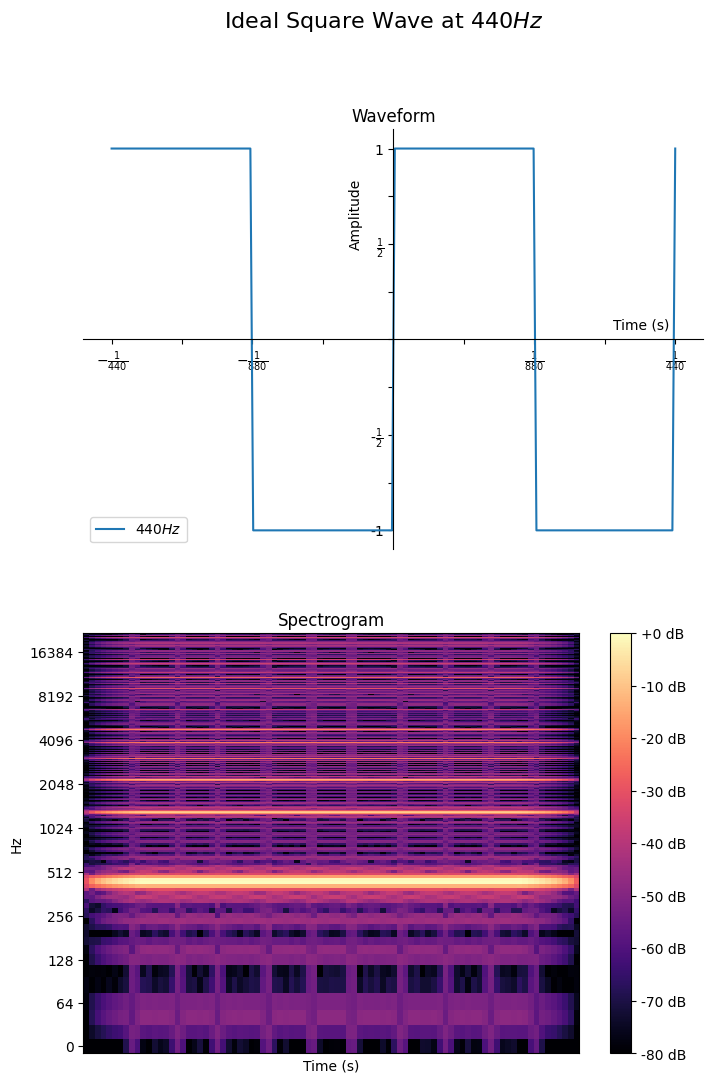

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

#NOTE: I am using two different time scales for the waveform
#and spectrograph outputs. I wanted to show both the shape of the wave 
#as well as the frequency distribution of the wave

#Generate the time-domain data
sampling_rate = 44100 
duration_time = 1 / 220
# Define the frequency (in Hz) of the sine wave 
frequency_time = 440
# Generate a time vector with evenly spaced samples 
t_time = np.linspace(0, duration_time, num=int(sampling_rate * duration_time))
# Generate the time-domain data
waveform_time = signal.square(2 * np.pi * frequency_time * t_time) 

# Plot the waveform 
ax1.plot(t_time, waveform_time) 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Amplitude') 

#Format top axis
ax1.title.set_text('Waveform')

ax1.spines['left'].set_position(('data', 1 / 440))
ax1.spines['bottom'].set_position(('data', 0))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.xaxis.set_label_coords(0.9,0.55)
ax1.set_xticks([x / 1760 for x in range(9)], labels=[r'$-\frac{1}{440}$', '', r'$-\frac{1}{880}$', '', '', '', r'$\frac{1}{880}$', '', r'$\frac{1}{440}$'])

ax1.set_yticklabels(['', '-1', '', r'-$\frac{1}{2}$', '','', '', r'$\frac{1}{2}$', '', '1', ''])
ax1.yaxis.set_label_coords(0.45,0.8)

frequency_handle = Line2D([0], [0], label='$440 Hz$', color=ax1.get_lines()[0].get_color())
ax1.legend(handles=[frequency_handle])


#Generate the frequency-domain data
#Notice that the duration of the two graphs are different!!
duration_freq = 1
frequency_freq = 440
t_freq = np.linspace(0, duration_freq, num=int(sampling_rate * duration_freq))#, endpoint=False) 

#Because of the hilarious behaviour of discontinuities, I'm smoothing the
#beginnings and endings of the clip to avoid artifacts in the 
#spectrograms
ramp_len = 5000
amp_smooth = np.ones(t_freq.shape[0])
amp_smooth[:ramp_len] = (1 / ramp_len) * np.arange(ramp_len) 
amp_smooth[t_freq.shape[0]: t_freq.shape[0] - ramp_len - 1: -1] = (1 / ramp_len) * np.arange(ramp_len) 

waveform_freq = signal.square(2 * np.pi * frequency_time * t_freq) 
waveform_freq_squ = waveform_freq * amp_smooth

#Short-Time Fourier transform to get a list of lists of frequency bin 
#intensities
D = librosa.stft(waveform_freq_squ)#waveform_freq)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
#Hahaha, a few hours of frustrating graphing, I realized
#Librosa's spechow defaults to using a sampling rate
#of 22050 Hz
img = librosa.display.specshow(S_db, y_axis='log', ax=ax2, sr=sampling_rate)
fig.colorbar(img, ax=ax2, format="%+2.f dB")
ax2.title.set_text('Spectrogram')
ax2.set_xlabel('Time (s)') 
fig.suptitle('Ideal Square Wave at $440 Hz$', fontsize=16)
plt.show() 

In [46]:
Audio(waveform_freq_squ, rate=sampling_rate)


<p>In an ideal square wave, the transitions between the two amplitude values are instantaneous. Attempting to mimic this amplitude jump in a discrete-time enviroment results in a type of audio distortion called <em>aliasing</em>. You can see that the spectrogram is extremely dense and noisy in places that it probably shouldn't be (e.g. there are bright bands of frequencies below the 440 Hz fundamental frequency!!)</p>
    
<p>There is some cool discussions to be had here but to avoid being too long-winded, the way to avoid aliasing in recording is to ensure to remove all of the harmonic content above half of the sampling rate.</p>

<p>$$f \lt \frac{f_{sr}}{2}$$</p>

<p>Since human hearing range is roughly 20 Hz - 20 kHz (adults usually have a much smaller range), modern audio equipment can sample audio above 40 kHz (two times the upper human range). Most of this equipment accomplishes this by applying a sharp, linear-phase  low-pass pass filter to cut out frequencies above the 40 kHz + range.</p>

<p>We won't filter an ideal square wave to get something less distorted but we will take the Fourier transform of the ideal square wave and additively put together an anti-aliased waveform. With all the necessary hand-waving, the equation for the Fourier transform of a square wave is:</p>

<p>$$\displaystyle x_{square}(t; f) = \frac{4}{\pi} \sum_{k=1}^{\infty} \frac{sin(2 \pi (2 k - 1) f t)}{2 k - 1}$$</p>

<p>Instead of taking the sum to infinity, we will sum at most:</p>
$$\displaystyle (2 N - 1)f \lt \frac{f_{sr}}{2}$$
$$N \lt \frac{f_{sr}}{4 \; f} + \frac{1}{2}$$

<p>terms of the Fourier expansion.</p>

<p>Hefty asterisk here: The above sum can be extremely inefficient to compute directly in the real world. When Fourer transforms are needed, most cool cats use the Fast-Fourier Transform (FFT). We won't be cool. We will sum sinusoidals like our ancestors.</p>

In [132]:
#Generate the time-domain data
sampling_rate = 44100 
# Define the frequency (in Hz) of the sine wave 
frequency_time = 440

#Find the maximum number of terms to sum before we get aliasing
max_harm = int(sampling_rate / (4 * frequency_time) + 1 / 2)

print(max_harm)

25


In [133]:
harms = [5, 10, 25]

# Generate a time vector with evenly spaced samples 
duration_time = 1 / 220

t_time = np.linspace(0, duration_time, num=int(sampling_rate * duration_time))

#I am going to use linearized approach to the Fourier Transform sum
wave_time = [np.array([t_time for i in range(1, harm + 1)]) for harm in harms]

#Transform the partials for each waveform
for j in range(len(harms)):
    for i in range(1, harms[j] + 1): 
        wave_time[j][i - 1] = (np.sin(2 * np.pi * (2 * i - 1) * frequency_time * wave_time[j][i - 1])) / (2 * i - 1)

#Sum the the partials for each waveform on each sample
wave_time = [(4 / np.pi) * (np.sum(i, axis=0)) for i in wave_time]

In [134]:
#Generate the frequency-domain data
#Notice that the duration of the two graphs are different!!
duration_freq = 1
frequency_freq = 440
t_freq = np.linspace(0, duration_freq, num=int(sampling_rate * duration_freq))#, endpoint=False) 

#Because of the hilarious behaviour of discontinuities, I'm smoothing the
#beginnings and endings of the clip to avoid artifacts in the 
#spectrograms
ramp_len = 5000
amp_smooth = np.ones(t_freq.shape[0])
amp_smooth[:ramp_len] = (1 / ramp_len) * np.arange(ramp_len) 
amp_smooth[t_freq.shape[0]: t_freq.shape[0] - ramp_len - 1: -1] = (1 / ramp_len) * np.arange(ramp_len) 


#I am going to attempt a linearized approach to the Fourier Transform sum
wave_freq = [np.array([t_freq for i in range(1, harm + 1)]) for harm in harms]

#Transform the partials for each waveform
for j in range(len(harms)):
    for i in range(1, harms[j] + 1): 
        wave_freq[j][i - 1] = (np.sin(2 * np.pi * (2 * i - 1) * frequency_freq * wave_freq[j][i - 1])) / (2 * i - 1)

#Sum the sum the partials for each waveform and smooth 
wave_freq_squ = [(4 * np.sum(i, axis=0) / np.pi) * amp_smooth for i in wave_freq]

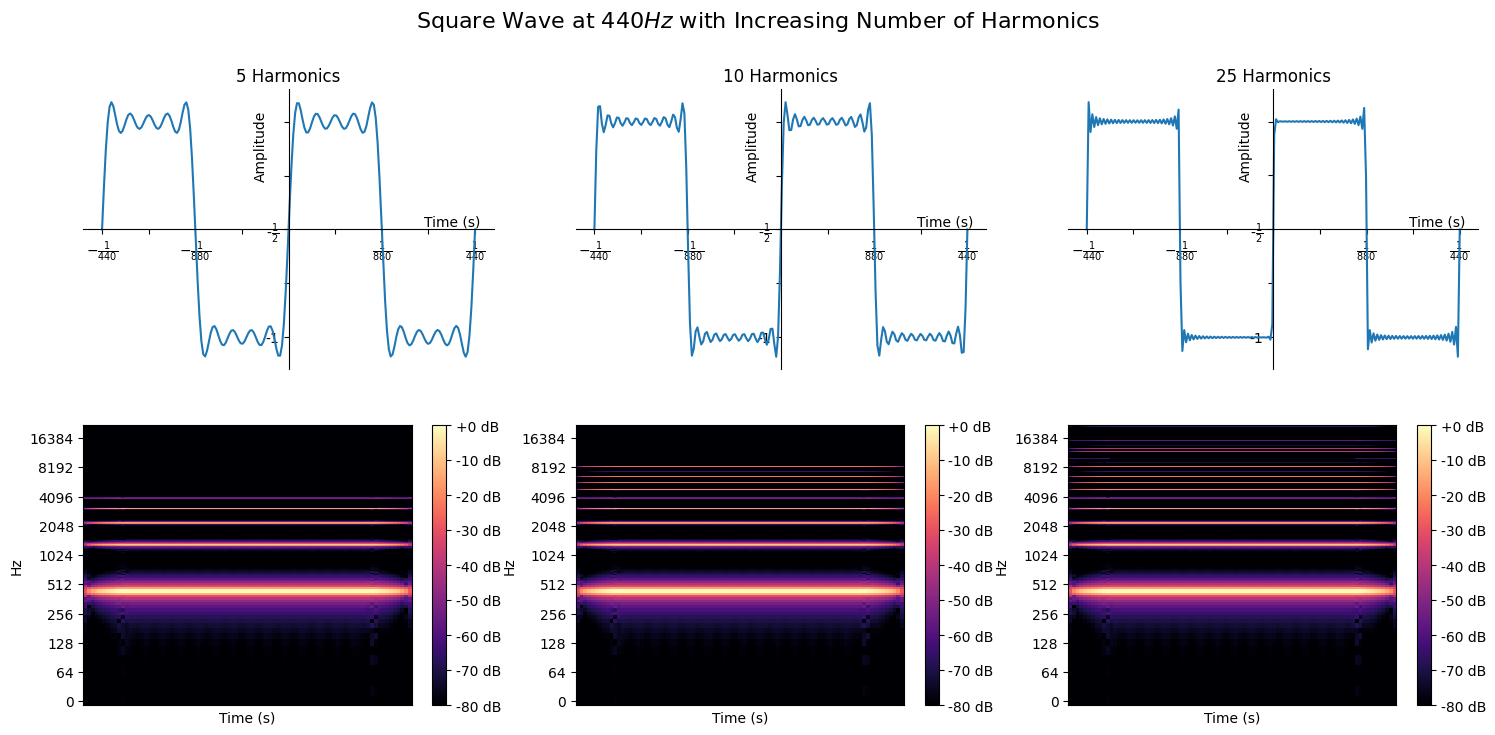

In [135]:
fig, ((top), (bottom)) = plt.subplots(2, 3, figsize=(18, 8))

for i, ax in enumerate(top):
    ax.plot(t_time, wave_time[i])
    
    ax.set_xlabel('Time (s)') 
    ax.set_ylabel('Amplitude') 
    ax.title.set_text('{} Harmonics'.format(harms[i]))
    ax.spines['left'].set_position(('data', 1 / 440))
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_label_coords(0.9,0.55)
    ax.set_xticks([x / 1760 for x in range(9)], labels=[r'$-\frac{1}{440}$', '', r'$-\frac{1}{880}$', '', '', '', r'$\frac{1}{880}$', '', r'$\frac{1}{440}$'])
    ax.set_yticklabels(['', '-1', '', r'-$\frac{1}{2}$', '','', '', r'$\frac{1}{2}$', '', '1', ''])
    ax.yaxis.set_label_coords(0.45,0.8)

for i, ax in enumerate(bottom):
    D = librosa.stft(wave_freq_squ[i])
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, y_axis='log', ax=ax, sr=sampling_rate)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    ax.set_xlabel('Time (s)') 
fig.suptitle('Square Wave at $440 Hz$ with Increasing Number of Harmonics', fontsize=16)
plt.show() 

In [136]:
# 5 harmonics
Audio(wave_freq_squ[1], rate=sampling_rate)

In [137]:
# 15 harmonics
Audio(wave_freq_squ[1], rate=sampling_rate)

In [138]:
# 50 harmonics
Audio(wave_freq_squ[2], rate=sampling_rate)

<h3>Saw Wave</h3><p>This waveform looks like a ramp going from -1 to 1 and then jumps back, immediately to -1.</p>

<p>The ideal saw  wave with frequency $f$, at time $t$, and the floor function $\lfloor \; \rfloor$, is:</p>

<p>$$\displaystyle x(t) = 2\left( t f -\left\lfloor \frac {1}{2}+t f \right\rfloor \right)$$</p>

<p>As with the ideal square wave, there is a discontinuity with the ideal saw wave that can introduce aliasing. So, we will take use Fourier Transform:</p>

<p>$$\displaystyle x_{sawtooth}(t; f, N) = \frac{1}{2} - \frac{1}{\pi} \sum_{k=1}^{\infty} (-1)^{k} \frac{sin(2\pi k f t)}{k}$$</p>

<p>and, use at most $\displaystyle N  \lt \frac{f_{sr}}{2 \, f}$ terms of the Fourier Transform.</p>

<p>First, let's look at the ideal saw wave and then a few plots of different additive saw waves using the above equation.</p>

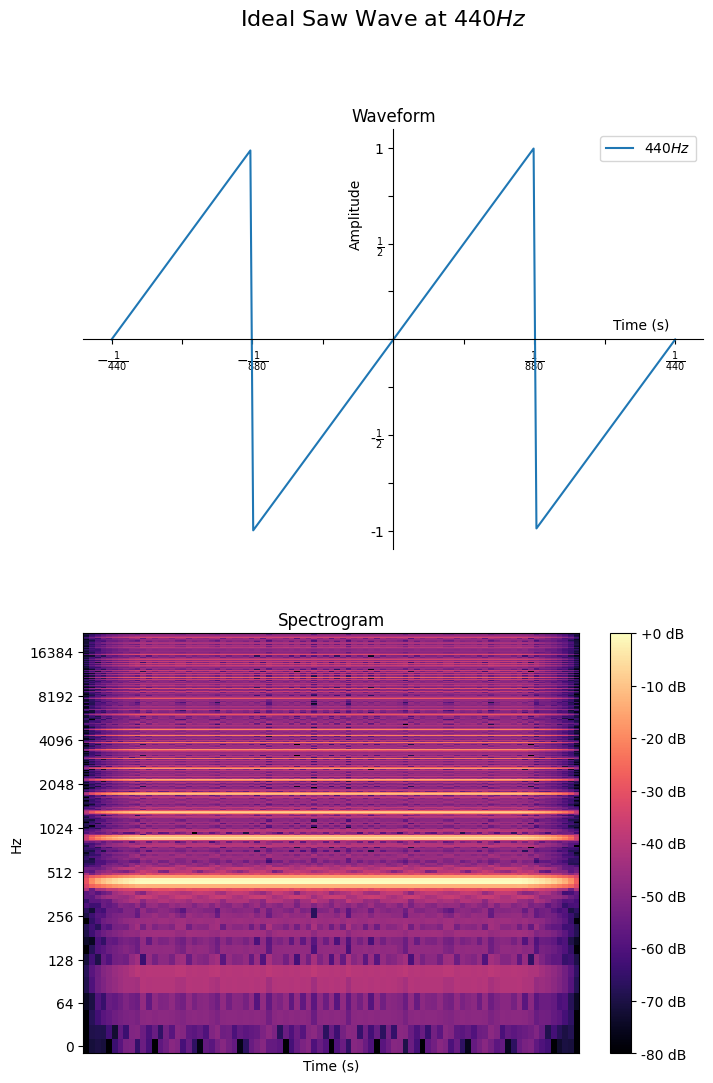

In [98]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

#NOTE: I am using two different time scales for the waveform
#and spectrograph outputs. I wanted to show both the shape of the wave 
#as well as the frequency distribution of the wave

#Generate the time-domain data
sampling_rate = 44100 
duration_time = 1 / 220
# Define the frequency (in Hz) of the sine wave 
frequency_time = 440
# Generate a time vector with evenly spaced samples 
t_time = np.linspace(0, duration_time, num=int(sampling_rate * duration_time))
# Generate the time-domain data
waveform_time = signal.sawtooth(2 * np.pi * frequency_time * t_time + np.pi) 

# Plot the waveform 
ax1.plot(t_time, waveform_time) 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Amplitude') 

#Format top axis
ax1.title.set_text('Waveform')

ax1.spines['left'].set_position(('data', 1 / 440))
ax1.spines['bottom'].set_position(('data', 0))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.xaxis.set_label_coords(0.9,0.55)
ax1.set_xticks([x / 1760 for x in range(9)], labels=[r'$-\frac{1}{440}$', '', r'$-\frac{1}{880}$', '', '', '', r'$\frac{1}{880}$', '', r'$\frac{1}{440}$'])

ax1.set_yticklabels(['', '-1', '', r'-$\frac{1}{2}$', '','', '', r'$\frac{1}{2}$', '', '1', ''])
ax1.yaxis.set_label_coords(0.45,0.8)

frequency_handle = Line2D([0], [0], label='$440 Hz$', color=ax1.get_lines()[0].get_color())
ax1.legend(handles=[frequency_handle])


#Generate the frequency-domain data
#Notice that the duration of the two graphs are different!!
duration_freq = 1
frequency_freq = 440
t_freq = np.linspace(0, duration_freq, num=int(sampling_rate * duration_freq))#, endpoint=False) 

#Because of the hilarious behaviour of discontinuities, I'm smoothing the
#beginnings and endings of the clip to avoid artifacts in the 
#spectrograms
ramp_len = 5000
amp_smooth = np.ones(t_freq.shape[0])
amp_smooth[:ramp_len] = (1 / ramp_len) * np.arange(ramp_len) 
amp_smooth[t_freq.shape[0]: t_freq.shape[0] - ramp_len - 1: -1] = (1 / ramp_len) * np.arange(ramp_len) 

waveform_freq = signal.sawtooth(2 * np.pi * frequency_time * t_freq) 
waveform_freq_saw = waveform_freq * amp_smooth

#Short-Time Fourier transform to get a list of lists of frequency bin 
#intensities
D = librosa.stft(waveform_freq_saw)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
#Hahaha, a few hours of frustrating graphing, I realized
#Librosa's spechow defaults to using a sampling rate
#of 22050 Hz
img = librosa.display.specshow(S_db, y_axis='log', ax=ax2, sr=sampling_rate)
fig.colorbar(img, ax=ax2, format="%+2.f dB")
ax2.title.set_text('Spectrogram')
ax2.set_xlabel('Time (s)') 
fig.suptitle('Ideal Saw Wave at $440 Hz$', fontsize=16)
plt.show() 

In [60]:
Audio(waveform_freq_saw, rate=sampling_rate)

<p>Woah, That is pretty noisy!</p>
<p>Anyways, let's additively construct a few anti-aliased saw waves.</p>

In [70]:
#Generate the time-domain data
sampling_rate = 44100 
# Define the frequency (in Hz) of the sine wave 
frequency_time = 440

#Find the maximum number of terms to sum before we get aliasing
max_harm = int(sampling_rate / (2 * frequency_time))

print(max_harm)

50


In [99]:
harms = [5, 15, 50]

# Generate a time vector with evenly spaced samples 
duration_time = 1 / 220

t_time = np.linspace(0, duration_time, num=int(sampling_rate * duration_time))#, endpoint=False) 

#I am going to use linearized approach to the Fourier Transform sum
wave_time = [np.array([t_time for i in range(1, harm + 1)]) for harm in harms]

#Transform the partials for each waveform
for j in range(len(harms)):
    for i in range(1, harms[j] + 1): 
        wave_time[j][i - 1] = np.power(-1, i) * (np.sin(2 * np.pi * i * frequency_time * wave_time[j][i - 1])) / i #(np.sin(2 * np.pi * (2 * i - 1) * frequency_time * wave_time[j][i - 1])) / (2 * i - 1)

#Sum the the partials for each waveform on each sample
wave_time = [ - (1 / np.pi) * np.sum(i, axis=0)  for i in wave_time]

In [100]:
#Generate the frequency-domain data
#Notice that the duration of the two graphs are different!!
duration_freq = 1
frequency_freq = 440
t_freq = np.linspace(0, duration_freq, num=int(sampling_rate * duration_freq))#, endpoint=False) 

#Because of the hilarious behaviour of discontinuities, I'm smoothing the
#beginnings and endings of the clip to avoid artifacts in the 
#spectrograms
ramp_len = 5000
amp_smooth = np.ones(t_freq.shape[0])
amp_smooth[:ramp_len] = (1 / ramp_len) * np.arange(ramp_len) 
amp_smooth[t_freq.shape[0]: t_freq.shape[0] - ramp_len - 1: -1] = (1 / ramp_len) * np.arange(ramp_len) 


#I am going to attempt linearized approach to the Fourier Transform sum
wave_freq = [np.array([t_freq for i in range(1, harm + 1)]) for harm in harms]

#Transform the partials for each waveform
for j in range(len(harms)):
    for i in range(1, harms[j] + 1): 
        wave_freq[j][i - 1] = np.power(-1, i) * (np.sin(2 * np.pi * i * frequency_freq * wave_freq[j][i - 1])) / i

#Sum the sum the partials for each waveform and smooth 
wave_freq_saw = [- (1 / np.pi) * np.sum(i, axis=0) * amp_smooth  for i in wave_freq]

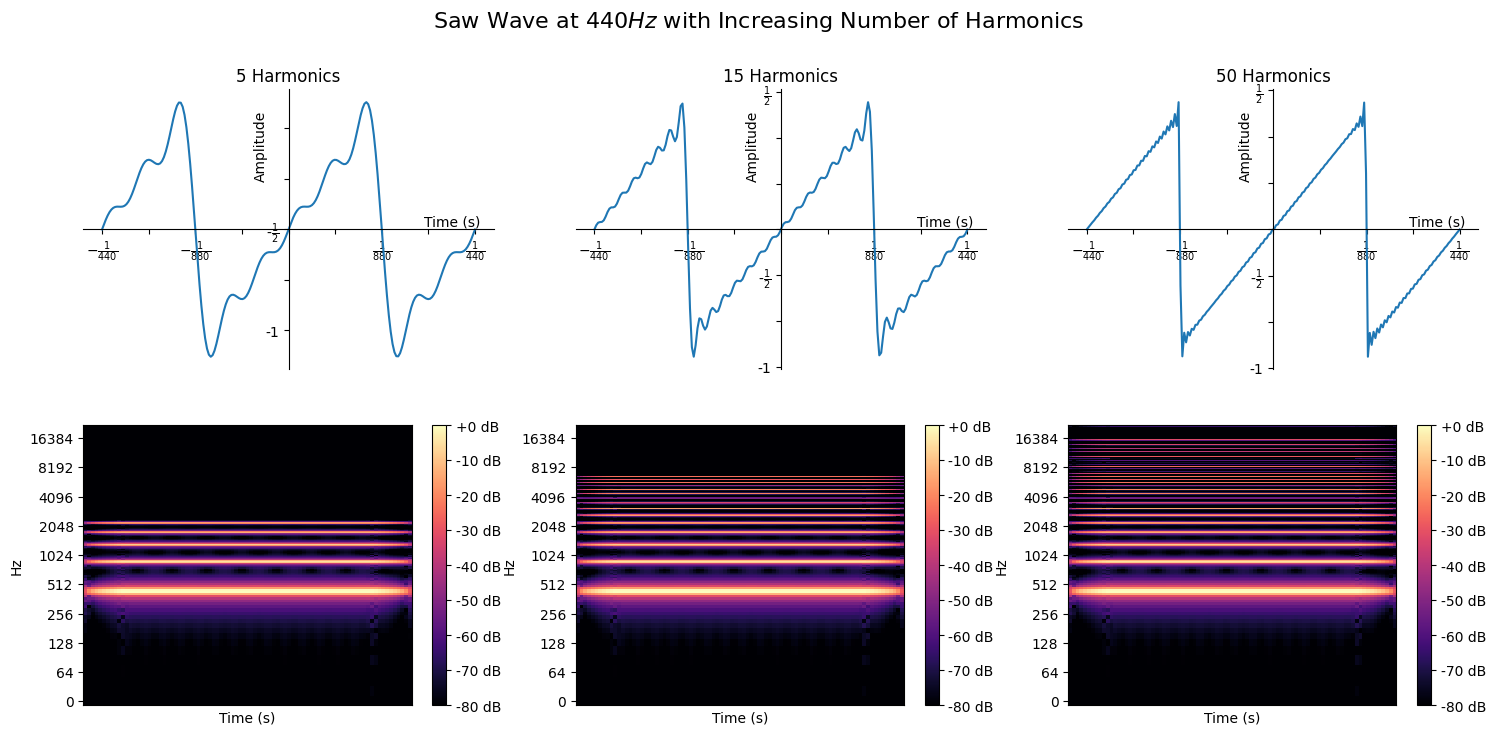

In [102]:
fig, ((top), (bottom)) = plt.subplots(2, 3, figsize=(18, 8))

for i, ax in enumerate(top):
    ax.plot(t_time, wave_time[i])
    
    ax.set_xlabel('Time (s)') 
    ax.set_ylabel('Amplitude') 
    ax.title.set_text('{} Harmonics'.format(harms[i]))
    ax.spines['left'].set_position(('data', 1 / 440))
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_label_coords(0.9,0.55)
    ax.set_xticks([x / 1760 for x in range(9)], labels=[r'$-\frac{1}{440}$', '', r'$-\frac{1}{880}$', '', '', '', r'$\frac{1}{880}$', '', r'$\frac{1}{440}$'])
    ax.set_yticklabels(['', '-1', '', r'-$\frac{1}{2}$', '','', '', r'$\frac{1}{2}$', '', '1', ''])
    ax.yaxis.set_label_coords(0.45,0.8)

for i, ax in enumerate(bottom):
    D = librosa.stft(wave_freq_saw[i])
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, y_axis='log', ax=ax, sr=sampling_rate)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    ax.set_xlabel('Time (s)') 
fig.suptitle('Saw Wave at $440 Hz$ with Increasing Number of Harmonics', fontsize=16)
plt.show() 

In [103]:
Audio(wave_freq_saw[0], rate=sampling_rate)

In [104]:
Audio(wave_freq_saw[1], rate=sampling_rate)

In [105]:
Audio(wave_freq_saw[2], rate=sampling_rate)

<h3>Triangle Wave</h3><p>This waveform looks like triangles going from -1 to 1.</p>

<p>The ideal triangle wave with frequency $f$, at time $t$, and the floor function $\lfloor \; \rfloor$, is:</p>

<p>$$\displaystyle x(t) = 2\left( t f -\left\lfloor \frac {1}{2}+t f \right\rfloor \right)$$</p>

<p>Although there aren't any discontinuities per say here, we will still take use Fourier Transform:</p>

<p>$$\displaystyle x_{triangle}(t; f) = \frac{8}{\pi^2} \sum_{k=0}^{\infty} \frac{(-1)^k  sin(2 \pi (2 k + 1) f t)}{(2 k + 1)^{2}}$$</p>

<p>and, use at most:</p>

$$\displaystyle (2 N + 1)f \lt \frac{f_{sr}}{2}$$
$$N \lt \frac{f_{sr}}{4 \; f} - \frac{1}{2}$$

<p>terms of the Fourier Transform.</p>
<p>Ideal first, then additive!</p>

In [140]:
#Generate the time-domain data
sampling_rate = 44100 
# Define the frequency (in Hz) of the sine wave 
frequency_time = 440

#Find the maximum number of terms to sum before we get aliasing
max_harm = int(sampling_rate / (4 * frequency_time) + 1 / 2)

print(max_harm)

25


In [141]:
harms = [5, 10, 25]

# Generate a time vector with evenly spaced samples 
duration_time = 1 / 220

t_time = np.linspace(0, duration_time, num=int(sampling_rate * duration_time))#, endpoint=False) 

#I am going to use linearized approach to the Fourier Transform sum
wave_time = [np.array([t_time for i in range(1, harm + 1)]) for harm in harms]

#Transform the partials for each waveform
for j in range(len(harms)):
    for i in range(harms[j]):
        wave_time[j][i] = np.power(-1, i) * (np.sin(2 * np.pi * (2 * i + 1) * frequency_time * wave_time[j][i])) / np.power(2 * i + 1, 2)

#Sum the the partials for each waveform on each sample
wave_time = [(8 / np.power(np.pi, 2)) * (np.sum(i, axis=0))  for i in wave_time]

In [142]:
#Generate the frequency-domain data
#Notice that the duration of the two graphs are different!!
duration_freq = 1
frequency_freq = 440
t_freq = np.linspace(0, duration_freq, num=int(sampling_rate * duration_freq))#, endpoint=False) 

#Because of the hilarious behaviour of discontinuities, I'm smoothing the
#beginnings and endings of the clip to avoid artifacts in the 
#spectrograms
ramp_len = 5000
amp_smooth = np.ones(t_freq.shape[0])
amp_smooth[:ramp_len] = (1 / ramp_len) * np.arange(ramp_len) 
amp_smooth[t_freq.shape[0]: t_freq.shape[0] - ramp_len - 1: -1] = (1 / ramp_len) * np.arange(ramp_len) 


#I am going to attempt linearized approach to the Fourier Transform sum
wave_freq = [np.array([t_freq for i in range(1, harm + 1)]) for harm in harms]

#Transform the partials for each waveform
for j in range(len(harms)):
    for i in range(harms[j]):
        wave_freq[j][i] = np.power(-1, i) * (np.sin(2 * np.pi * (2 * i + 1) * frequency_freq * wave_freq[j][i])) / np.power(2 * i + 1, 2)

#Sum the the partials for each waveform on each sample
wave_freq_tri = [(8 / np.power(np.pi, 2)) * (np.sum(i, axis=0)) * amp_smooth  for i in wave_freq]

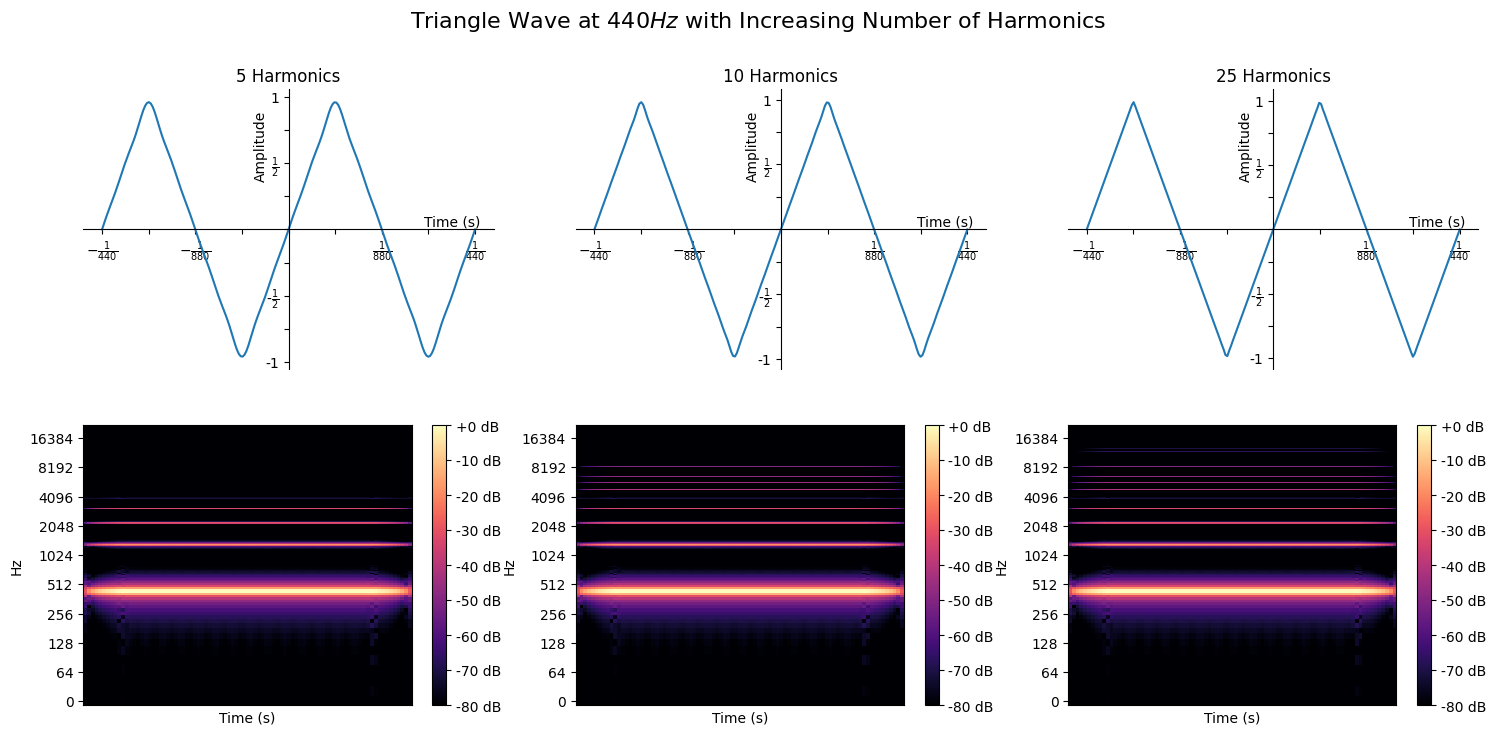

In [144]:
fig, ((top), (bottom)) = plt.subplots(2, 3, figsize=(18, 8))

for i, ax in enumerate(top):
    ax.plot(t_time, wave_time[i])
    
    ax.set_xlabel('Time (s)') 
    ax.set_ylabel('Amplitude') 
    ax.title.set_text('{} Harmonics'.format(harms[i]))
    ax.spines['left'].set_position(('data', 1 / 440))
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_label_coords(0.9,0.55)
    ax.set_xticks([x / 1760 for x in range(9)], labels=[r'$-\frac{1}{440}$', '', r'$-\frac{1}{880}$', '', '', '', r'$\frac{1}{880}$', '', r'$\frac{1}{440}$'])
    ax.set_yticklabels(['', '-1', '', r'-$\frac{1}{2}$', '','', '', r'$\frac{1}{2}$', '', '1', ''])
    ax.yaxis.set_label_coords(0.45,0.8)

for i, ax in enumerate(bottom):
    D = librosa.stft(wave_freq_tri[i])
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, y_axis='log', ax=ax, sr=sampling_rate)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    ax.set_xlabel('Time (s)') 
fig.suptitle('Triangle Wave at $440 Hz$ with Increasing Number of Harmonics', fontsize=16)
plt.show() 

In [ ]:
Audio(wave_freq_tri[0], rate=sampling_rate)

In [ ]:
Audio(wave_freq_tri[1], rate=sampling_rate)

In [ ]:
Audio(wave_freq_tri[2], rate=sampling_rate)